Loading train/test splits...
X_train shape: (3392, 15)
X_test shape: (848, 15)

Starting repeated sub-sampling with GridSearch and threshold optimization...

--- Seed 0 ---

--- Seed 1 ---

--- Seed 2 ---

--- Seed 3 ---

--- Seed 4 ---

--- Seed 5 ---

--- Seed 6 ---

--- Seed 7 ---

--- Seed 8 ---

--- Seed 9 ---

--- Seed 10 ---

--- Seed 11 ---

--- Seed 12 ---

--- Seed 13 ---

--- Seed 14 ---

--- Seed 15 ---

--- Seed 16 ---

--- Seed 17 ---

--- Seed 18 ---

--- Seed 19 ---

Classification Report (best F1 via thresholding):
              precision    recall  f1-score   support

           0       0.93      0.71      0.80       719
           1       0.29      0.68      0.41       129

    accuracy                           0.70       848
   macro avg       0.61      0.69      0.61       848
weighted avg       0.83      0.70      0.74       848



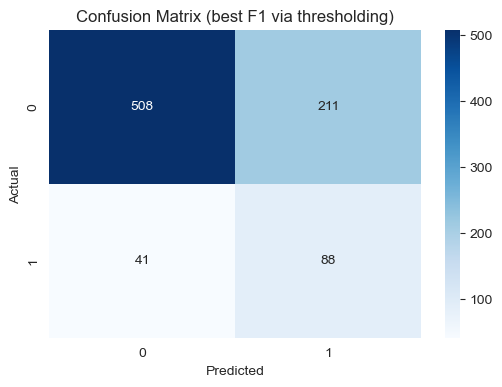


=== Summary over multiple subsamplings ===
           seed          C  best_threshold    best_f1
count  20.00000  20.000000       20.000000  20.000000
mean    9.50000   1.564000        0.512121   0.380919
std     5.91608   5.569956        0.016419   0.017075
min     0.00000   0.010000        0.484848   0.337812
25%     4.75000   0.010000        0.502525   0.374084
50%     9.50000   0.100000        0.510101   0.383603
75%    14.25000   0.325000        0.525253   0.392420
max    19.00000  25.000000        0.545455   0.411215
Saved results to ../results/lasso_repeated_subsampling_thresholds.csv


In [16]:
# --- 03_lasso_regression_gridsearch_subsampling.ipynb ---

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.utils import resample
import shap

# 1. Load preprocessed data
print("Loading train/test splits...")
X_train = np.load("../data/splits/X_train.npy")
y_train = np.load("../data/splits/y_train.npy")
X_test = np.load("../data/splits/X_test.npy")
y_test = np.load("../data/splits/y_test.npy")

# Convert numpy arrays back to pandas DataFrame
X_train_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
X_train = pd.DataFrame(X_train, columns=X_train_columns)
X_test = pd.DataFrame(X_test, columns=X_train_columns)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}\n")

# 2. Set up GridSearchCV for Lasso Logistic Regression
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5,
          0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5,
          4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0,
          25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0,
          70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 150.0,
          200.0, 250.0, 300.0, 400.0, 500.0],
    'penalty': ['l1'],
    'solver': ['liblinear'],
}

print("Starting repeated sub-sampling with GridSearch and threshold optimization...")

results_list = []

# Listen für spätere Auswahl des besten Laufs
all_best_f1s = []
all_models = []
all_thresholds = []
all_probs = []

for seed in range(20):
    print(f"\n--- Seed {seed} ---")
    # Down-sample majority class
    X_minority = X_train[y_train == 1]
    y_minority = y_train[y_train == 1]

    X_majority = X_train[y_train == 0]
    y_majority = y_train[y_train == 0]

    X_majority_downsampled, y_majority_downsampled = resample(
        X_majority, y_majority,
        replace=False,
        n_samples=len(X_minority),
        random_state=seed
    )

    #X_resampled = np.vstack((X_majority_downsampled, X_minority))
    X_resampled = pd.concat([pd.DataFrame(X_majority_downsampled, columns=X_train.columns),
                         pd.DataFrame(X_minority, columns=X_train.columns)], ignore_index=True)

    y_resampled = np.hstack((y_majority_downsampled, y_minority))

    grid_search = GridSearchCV(
        LogisticRegression(max_iter=1000, random_state=seed),
        param_grid,
        scoring='f1',
        cv=5,
        verbose=0,
        n_jobs=-1
    )

    grid_search.fit(X_resampled, y_resampled)
    best_model = grid_search.best_estimator_

    y_probs = best_model.predict_proba(X_test)[:, 1]
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_test, (y_probs >= t).astype(int)) for t in thresholds]
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    results_list.append({
        'seed': seed,
        'C': grid_search.best_params_['C'],
        'best_threshold': best_threshold,
        'best_f1': best_f1
    })

    # Speichern für spätere Auswahl des besten Laufs
    all_best_f1s.append(best_f1)
    all_models.append(best_model)
    all_thresholds.append(best_threshold)
    all_probs.append(y_probs)

# === Pick best model across all seeds ===
best_result_idx = np.argmax(all_best_f1s)
final_model = all_models[best_result_idx]
final_threshold = all_thresholds[best_result_idx]
final_probs = all_probs[best_result_idx]

# Final predictions using best threshold
final_preds = (final_probs >= final_threshold).astype(int)

# Classification report
print("\nClassification Report (best F1 via thresholding):")
print(classification_report(y_test, final_preds))

# Confusion matrix
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (best F1 via thresholding)")
plt.show()

# Convert to DataFrame and show results
results_df = pd.DataFrame(results_list)
print("\n=== Summary over multiple subsamplings ===")
print(results_df.describe())

# Save results
os.makedirs("../results", exist_ok=True)
results_df.to_csv("../results/lasso_repeated_subsampling_thresholds.csv", index=False)
print("Saved results to ../results/lasso_repeated_subsampling_thresholds.csv")
